In [2]:
from droplet_growth import register as r
from droplet_growth import count, mic, fit, multiwell
import napari
import numpy as np
import tifffile as tf
import cupy
import aicsimageio
import dask as da
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [35]:
v = napari.Viewer()

In [45]:
v.add_image(meanIP[:], contrast_limits=(440,600))

<Image layer 'meanIP' at 0x7fc67e485a90>

In [141]:
arr = aicsimageio.AICSImage(
    '/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/00ng-timelapse-TRITC-30\'.nd2')

In [24]:
arr = aicsimageio.AICSImage(
    '/home/aaristov/Anchor/Lena/Data/20211220-MIC/movies-24h/64ng-25fps.nd2')

In [4]:
arr.channel_names

['CSU 561']

In [5]:
arr.dims

<Dimensions [T: 1, C: 1, Z: 25, Y: 7387, X: 22393]>

In [6]:
arr.dask_data

dask.array<transpose, shape=(1, 1, 25, 7387, 22393), dtype=uint16, chunksize=(1, 1, 1, 7387, 22393), chunktype=numpy.ndarray>

In [13]:
arr.dask_data.rechunk((1,1,25,1000,1000))

dask.array<rechunk-merge, shape=(1, 1, 25, 7387, 22393), dtype=uint16, chunksize=(1, 1, 25, 1000, 1000), chunktype=numpy.ndarray>

In [56]:
mean = arr.dask_data[0,0,0].mean().compute()

In [57]:
std = arr.dask_data[0,0,0].std().compute()

In [46]:
BF = aicsimageio.AICSImage(
    '/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/00ng-timelapse-BF.nd2').dask_data
BF

dask.array<transpose, shape=(1, 1, 1, 7387, 22393), dtype=uint16, chunksize=(1, 1, 1, 7387, 22393), chunktype=numpy.ndarray>

In [46]:
fluo = aicsimageio.AICSImage(
    '/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/00ng-timelapse-TRITC-30\'-MaxIP.nd2')

In [49]:
v.add_image(fluo.dask_data.compute(), contrast_limits=(440, 600))

<Image layer 'Image' at 0x7fc588cd1190>

In [51]:
bf = aicsimageio.AICSImage('/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/00ng-timelapse-BF.nd2').dask_data.compute()

In [62]:
v.add_image(bf)

<Image layer 'bf [1]' at 0x7fc67ee2b610>

In [60]:
v.layers[2].data = viewer.layers[2].data.reshape((7387, 22393))

In [63]:
v.layers[0].data = viewer.layers[0].data.reshape((7387, 22393))

In [55]:
fluo.physical_pixel_sizes

PhysicalPixelSizes(Z=None, Y=0.6689905570125603, X=0.6689905570125603)

In [48]:
maxIP = aicsimageio.AICSImage(
    '/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/00ng-timelapse-TRITC-30\'-MaxIP.nd2').dask_data
maxIP

dask.array<transpose, shape=(21, 1, 1, 7387, 22393), dtype=uint16, chunksize=(1, 1, 1, 7387, 22393), chunktype=numpy.ndarray>

In [39]:
meanIP = aicsimageio.imread_dask('/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/00ng-timelapse-TRITC-30\'-MeanIP.tif')

Failed to parse XML for the provided file.
not well-formed (invalid token): line 1, column 6


In [42]:
labels = tf.imread('/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/labels.tif')

In [43]:
v.add_image(labels, name='labels')

<Image layer 'labels' at 0x7fc67e5c5af0>

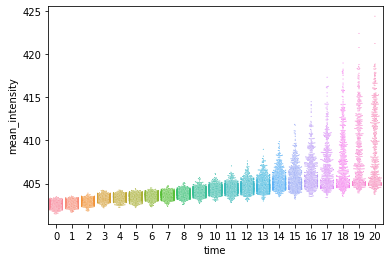

In [110]:
intensities = multiwell.get_intensity_table(labels, meanIP[:,0,0].compute(),)

In [111]:
intensities

time label  mean_intensity     bg_mean         I
0      0     1      402.533702  402.485294  0.048408
1      0     2      402.855800  402.617194  0.238607
2      0     3      403.315493  403.000000  0.315493
3      0     4      402.916445  402.705835  0.210611
4      0     5      402.934587  402.904020  0.030567
..   ...   ...             ...         ...       ...
496   20   497      405.644217  405.013115  0.631102
497   20   498      405.302182  405.214403  0.087779
498   20   499      404.880340  404.850040  0.030300
499   20   500      404.834343  404.647339  0.187004
500   20   501      404.811216  404.775594  0.035622

[10521 rows x 5 columns]

In [112]:
intensities.loc[:,'h'] = intensities.time * .5

In [113]:
intensities.to_csv('/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/intensities.csv', index=None)

In [2]:
intensities = pd.read_csv('/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/intensities.csv', index_col=None)
intensities

time  label  mean_intensity     bg_mean         I     h
0         0      1      402.533702  402.485294  0.048408   0.0
1         0      2      402.855800  402.617194  0.238607   0.0
2         0      3      403.315493  403.000000  0.315493   0.0
3         0      4      402.916445  402.705835  0.210611   0.0
4         0      5      402.934587  402.904020  0.030567   0.0
...     ...    ...             ...         ...       ...   ...
10516    20    497      405.644217  405.013115  0.631102  10.0
10517    20    498      405.302182  405.214403  0.087779  10.0
10518    20    499      404.880340  404.850040  0.030300  10.0
10519    20    500      404.834343  404.647339  0.187004  10.0
10520    20    501      404.811216  404.775594  0.035622  10.0

[10521 rows x 6 columns]

In [3]:
intensities = pd.read_csv('/home/aaristov/Anchor/Lena/Data/20220111-MIC-resistant/timelapse-30min/intesities.csv', index_col=None)
intensities

time  label  mean_intensity     bg_mean         I     h
0         0      1      403.468522  403.408795  0.059727   0.0
1         0      2      403.756794  403.612928  0.143866   0.0
2         0      3      403.698461  403.499611  0.198850   0.0
3         0      4      402.682343  402.763376 -0.081033   0.0
4         0      5      402.643138  402.638027  0.005111   0.0
...     ...    ...             ...         ...       ...   ...
19534    38    497      402.176094  402.185833 -0.009739  19.0
19535    38    498      402.465130  402.617599 -0.152468  19.0
19536    38    499      402.053269  402.165595 -0.112326  19.0
19537    38    500      402.410064  402.420667 -0.010603  19.0
19538    38    501      402.280297  401.862614  0.417682  19.0

[19539 rows x 6 columns]

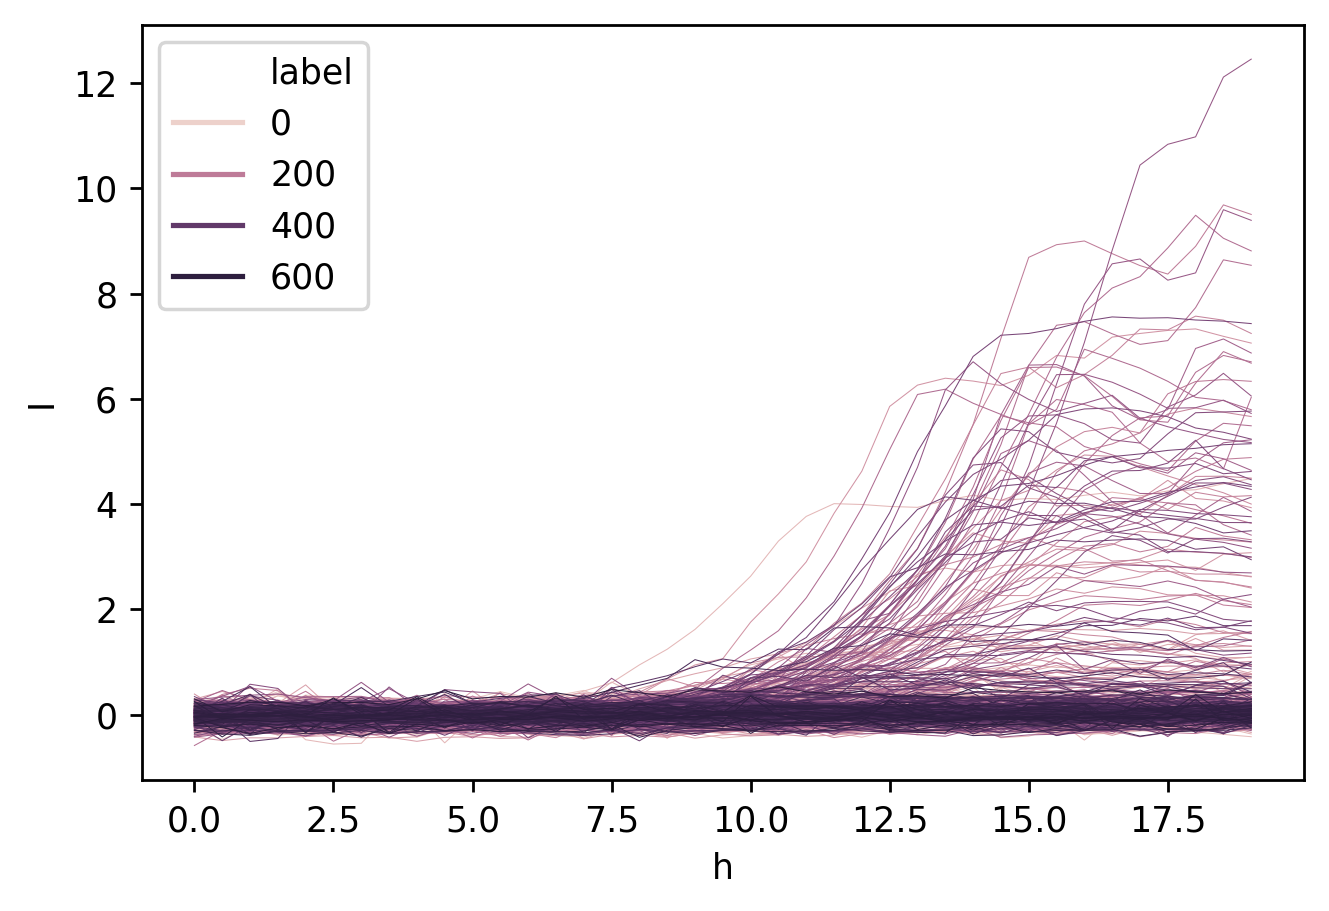

In [4]:
fig, ax = plt.subplots(dpi=250)
sns.lineplot(ax=ax, data=intensities, x='h', y='I', estimator=None, units='label', lw=.3, hue='label')

In [5]:
intensities_f = multiwell.filter_table_by_min_intensity(intensities, column='I', time=20, min_intensity=3)

/home/aaristov/Documents/nd2shrink/droplet_growth/multiwell.py:307: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return table[table[table.time == time].loc[:, column] > min_intensity]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

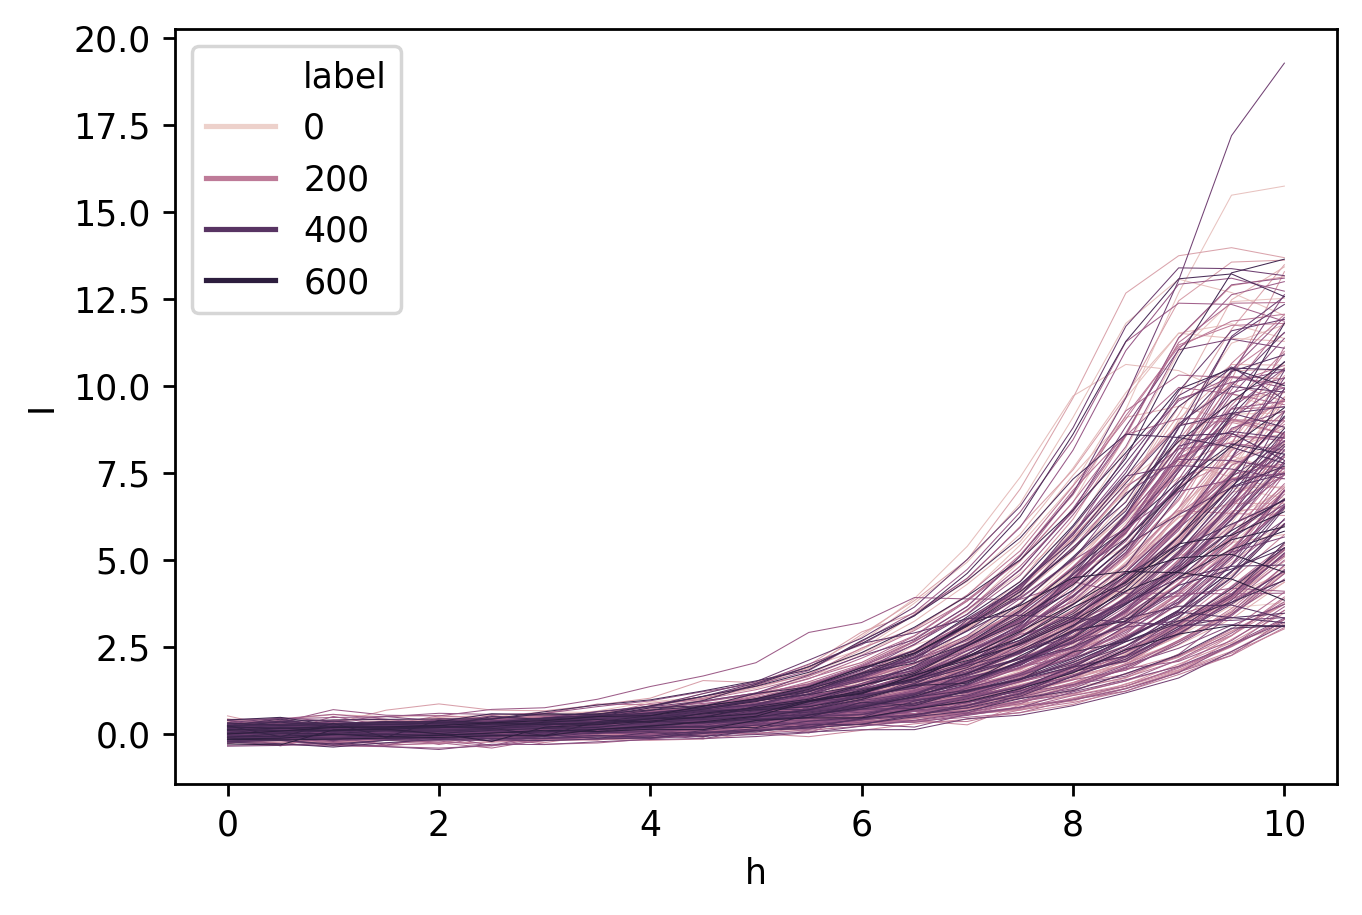

In [130]:
fig, ax = plt.subplots(dpi=250)
sns.lineplot(ax=ax, data=intensities_f, x='h', y='I', estimator=None, units='label', lw=.3, hue='label')

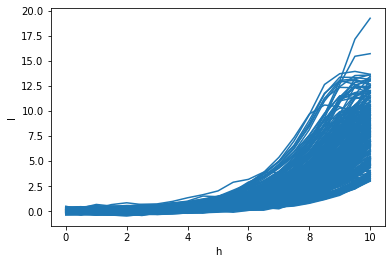

In [131]:
multiwell.plot_intensity_raw_line(intensities_f,x='h', y='I')

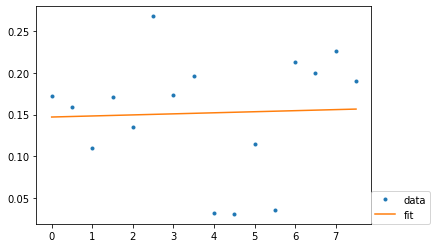

In [6]:
(c := intensities.query(f'label == 240 and h < 8'))
# c.plot('h', 'I')
base, pre, rate = fit.fit_exp_on_baseline(c.I, c.h, plot='linear')

In [10]:
dt = np.log(2) / rate
dt

1.1325560446176104

In [ ]:
def fit_growth(curve, time, fun=fit.exp_on_baseline):
    opt, pcov = fit.curve_fit(f=fun, x=time, y=curve,)
    return {}

No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit


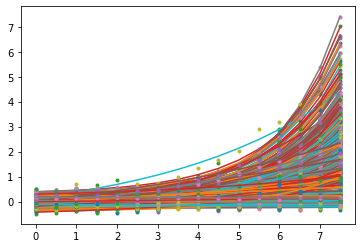

In [19]:
fits = [fit.fit_exp_on_baseline((c := intensities.query(f'label == {i} and h < 8')).I, x=c.h, plot='linear', markers=['.', '-'], legend=False )
        for i in intensities.label.unique()[:]]

plt.show()

In [20]:
fits_df = pd.DataFrame(list(filter(lambda x: x[0] is not None, fits)), columns=('base', 'pre', 'rate'))
fits_df

base         pre      rate
0      1.672272   -1.498029 -0.090157
1    203.889924 -203.667970 -0.000021
2      0.045966    0.096916  0.296462
3     -0.518977    0.477925  0.156857
4     -0.133545    0.072356  0.282118
..          ...         ...       ...
439   -0.166025    0.178148  0.064491
440 -887.403705  887.384280  0.000029
441 -458.314534  458.304337  0.000043
442 -169.275791  169.437598 -0.000003
443   78.304056  -78.137049  0.000049

[444 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc69776fb50>]],
      dtype=object)

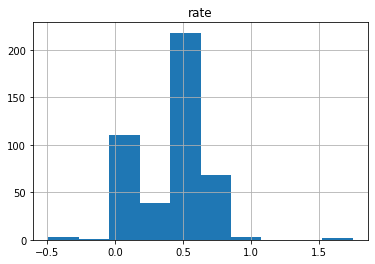

In [21]:
fits_df.hist('rate')

In [22]:
fits_df.loc[:,'douling time, h'] = np.log(2)/fits_df.rate

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93edd7f520>]],
      dtype=object)

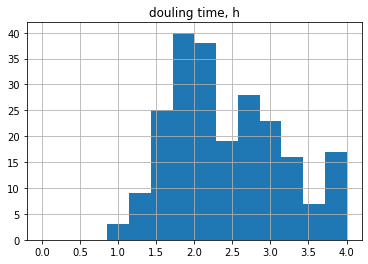

In [104]:
fits_df.hist('douling time, h', bins=np.linspace(0,4,15))

Text(0.5, 1.0, 'Doubling time of resistant strain on chip')

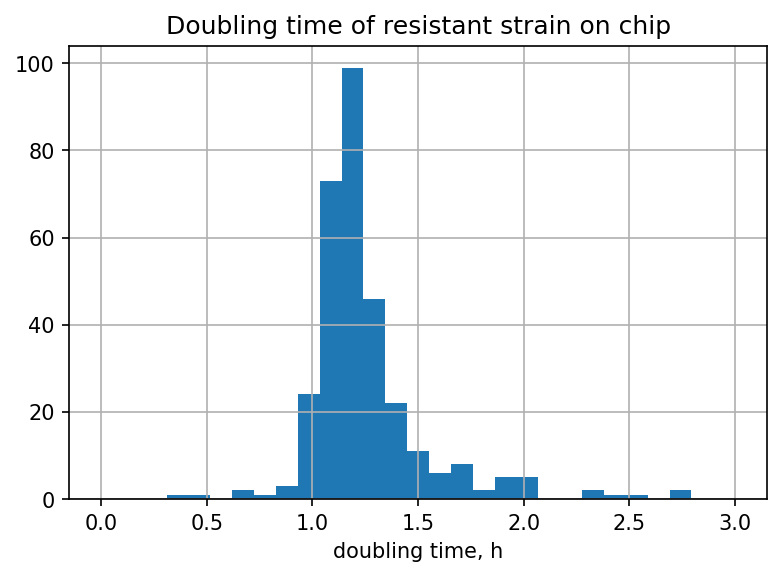

In [34]:
fig, ax = plt.subplots(dpi=150)
fits_df.query('0<pre<.2').hist('douling time, h', bins=np.linspace(0,3,30), ax=ax)
plt.xlabel('doubling time, h')
plt.title('Doubling time of resistant strain on chip')

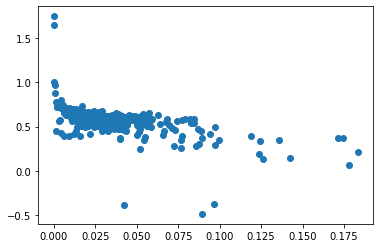

In [33]:
plt.scatter('pre','rate',data=fits_df.query('0<pre<.2'))

In [12]:
pd.DataFrame(intensities[0])

label   centroid-0    centroid-1  mean_intensity
0        1   353.385273  20450.791350      402.533702
1        2   393.406085  19918.929643      402.855800
2        3   433.237189  19392.377825      403.315493
3        4   473.457621  18862.344839      402.916445
4        5   513.781280  18335.968717      402.934587
..     ...          ...           ...             ...
496    497  6997.920183   2893.408624      402.803639
497    498  7038.092102   2366.325120      403.219811
498    499  7077.403273   1838.636989      402.810014
499    500  7117.854477   1310.989293      402.908627
500    501  7158.240081    778.987795      402.985935

[501 rows x 4 columns]

In [142]:
# v.add_image(BF, name='BF', colormap='gray', blending='additive', opacity=.5)
v.add_image(maxIP, name='maxIP', colormap='inferno', blending='additive', opacity=1)


<Image layer 'maxIP' at 0x7fa349c67b80>

In [29]:
template = tf.imread('/home/aaristov/Anchor/Lena/Data/20210518_control/template_bin16_bf_mask.tif')[0]
template.shape

(818, 2612)

In [32]:
mask = tf.imread('/home/aaristov/Anchor/Lena/Data/labels_bin2+100.tif')

In [35]:
tvec_8 = r.register(r.pad(template, bf.shape), (bf:=BF[0,0,0,::8,::8].compute()))

AICSImageIO: Reader will load image in-memory: False


In [36]:
tvec = r.scale_tvec(tvec_8, 8)

In [97]:
aligned_mask = r.transform(r.pad(mask, BF[0,0,0].shape), tvec)

input (7387, 22393)


In [98]:
aligned_mask = mic.segment.label(aligned_mask>0)

In [99]:
aligned_mask.shape

(7387, 22393)

In [143]:
v.add_image(aligned_mask, name='mask', colormap='blue', blending='additive', opacity=.5)

<Image layer 'mask' at 0x7fa349e2c1c0>

In [135]:
tf.imwrite('/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/labels.tif', aligned_mask, )

In [137]:
def do_counts(fluo, labels=aligned_mask, thr=mean+10*std):
    frame_idx, fluo = fluo
    maxIP = fluo[0,0].compute()
    print(frame_idx, maxIP.shape)
    detections = count.peak_local_max_labels(maxIP, labels=labels, threshold_abs=thr, min_distance=5)
    peaks = np.zeros((len(detections), 6))
    peaks[:,-3:] = detections[:,:]
    peaks[:,0] = frame_idx
    return peaks


In [138]:
peaks = list(map(do_counts, enumerate(maxIP)))

0 (7387, 22393)
1 (7387, 22393)
2 (7387, 22393)
3 (7387, 22393)
4 (7387, 22393)
5 (7387, 22393)
6 (7387, 22393)
7 (7387, 22393)
8 (7387, 22393)
9 (7387, 22393)
10 (7387, 22393)
11 (7387, 22393)
12 (7387, 22393)
13 (7387, 22393)
14 (7387, 22393)
15 (7387, 22393)
16 (7387, 22393)
17 (7387, 22393)
18 (7387, 22393)
19 (7387, 22393)
20 (7387, 22393)


In [144]:
v.add_points(np.concatenate(peaks, axis=0)[:,:5], name='detections', size=20, edge_width=3, edge_color="#ff00ff",face_color='#ffff0000', opacity=1)


<Points layer 'detections' at 0x7fa34a07cc10>

AICSImageIO: Reader will load image in-memory: False
AICSImageIO: Reader will load image in-memory: False


In [127]:
df = pd.DataFrame(data=np.concatenate(peaks, axis=0), columns=('frame','c','z','y','x','label'))
counts = df.groupby(['frame', 'label']).count().reset_index()

In [136]:
df.to_csv('/home/aaristov/Anchor/Lena/Data/20211220-MIC/timelapse/00ng-timelapse-TRITC-30\'-MaxIP.detections.csv', index=None)

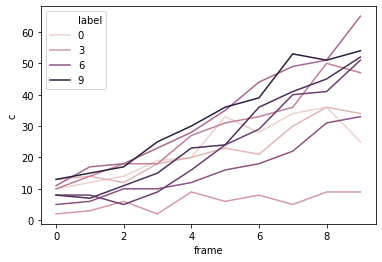

In [133]:
sns.lineplot(data=counts.query('frame < 10 and label < 10'), x='frame', y='c', hue='label', estimator=None, units='label')

In [86]:
v.layers[3].data

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.03045504e+03,
        1.85184221e+04],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.98970731e+03,
        1.85904994e+04]])

In [83]:
def get_transform_from_line(data, template):
    
    if data.shape[1] == 3:
        data = data[:,1:]
    
    trans = data.mean(axis=0) - template.mean(axis=0)


    vector = np.gradient(data[:2], axis=0)

    naive_angle_deg = np.arctan(np.true_divide(*vector[0])) / np.pi * 180
    zoom = np.sqrt((np.gradient(data[:2], axis=0) ** 2).sum() / (np.gradient(template[:2], axis=0) ** 2).sum())
    
    return {'tvec': -trans, 'angle': naive_angle_deg, 'scale': zoom}

In [42]:
viewer = napari.Viewer()

/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/napari/_qt/__init__.py:54: UserWarning: 

napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with
this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)


In [56]:
top_line = viewer.layers[1].data
top_line[0].shape

(2, 3)

In [84]:
tvec = get_transform_from_line(top_line[0], template)

In [69]:
bf, fluo = viewer.layers[0].data

In [59]:
l = viewer.layers[0]

In [85]:
bfa = r.transform(bf, tvec)

input (7019, 22259)


In [76]:
big_labels = tf.imread('/home/aaristov/Anchor/Lena/Data/labels_bin2+100.tif')


In [82]:
viewer.add_image(data=[big_labels], name='labels', colormap='blue', contrast_limits=[0,501], blending='additive')

<Image layer 'labels' at 0x7faf79115f40>

In [87]:
padded_big_labels = r.pad(big_labels, bf.shape)

In [88]:
viewer.add_image(data=[padded_big_labels], name='labels', colormap='blue', contrast_limits=[0,1], blending='additive')

<Image layer 'labels [1]' at 0x7faf7f1cd7f0>

In [98]:
template_line = viewer.layers[3].data[0]
template_line

array([[    0.        ,   910.35200753,  1075.14984244],
       [    0.        ,   973.69539982, 21281.69198341]])

In [99]:
tvec = get_transform_from_line(top_line[0], template_line[:, 1:])
tvec 

{'tvec': array([ -74.9135812 , -181.80175702]),
 'angle': -1.7534048600715766,
 'scale': 0.9972695147309522}

In [93]:
template_line[:, 1:]

array([[ 893.35991024, 1085.25866517],
       [ 944.74264507, 1136.6414    ]])

In [94]:
top_line[0]

array([[    0.        ,  1325.23369386,  1289.20664338],
       [    0.        ,   708.6408759 , 21431.2386965 ]])

In [100]:
bfa = r.transform(bf, tvec)

input (7019, 22259)


In [101]:
viewer.add_image(data=[bfa], name='aligned BF', colormap='gray')

<Image layer 'aligned BF' at 0x7faf80771c10>

In [102]:
labels = viewer.layers[3]

In [109]:
labels.translate = np.array([30, 120])

/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/ome_types/widgets.py:103: UserWarning: Could not parse OME metadata from /home/aaristov/Anchor/Lena/Data/20210705-MIC-0h/composites-24h/00ng-24h.aligned-big-labels.tif: not well-formed (invalid token): line 1, column 6
  warnings.warn(f"Could not parse OME metadata from {ome}: {e}")


AICSImageIO: Reader will load image in-memory: False
